# Benchmark an Endpoint

Welcome to this tutorial on benchmarking an endpoint deployed on a SambaNova dedicated node!

If you don't already have an endpoint deployed, please follow one of the workflows described in the [README](./README.md) to deploy an endpoint before proceeding with this tutorial.

Also, please install the benchmarking requirements in the Python kernel used in this Jupyter notebook

`! pip install -r ../../benchmarking/requirements.txt`

## 1.  Imports

In [1]:
import sys
sys.version

'3.11.11 (main, Dec 11 2024, 10:28:39) [Clang 14.0.6 ]'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
import json
import os
import pprint
import getpass
import pandas as pd
pd.set_option('display.max_columns', None)

In [3]:
benchmarking_dir = "../../benchmarking/"
sys.path.append(benchmarking_dir + "benchmarking_scripts")
sys.path.append(benchmarking_dir + "prompts")

from synthetic_performance_eval_script import *

## 2. Get endpoint info
To benchmark the endpoint, we will need to obtain some of its information. Note that this information can be obtained from your SambaNova representative.

#### Enter the endpoint url
Run the cell below and then enter the endpoint URL. This should be in the format of `https://my.env/v1/<endpoint_id>/chat/completions` 

In [4]:
endpoint_url = input().strip()
if endpoint_url[-1] == "/":
    endpoint_url = endpoint_url[:-1]
os.environ["SAMBASTUDIO_URL"] = endpoint_url
endpoint_id = endpoint_url.split('/')[-3]
print("Benchmarking Endpoint:", endpoint_id)
endpoint_url

Benchmarking Endpoint: d6cff577-782d-4b6f-b6fe-afcefeeec6bb


'https://sjc3-tsint.sambanova.net/v1/d6cff577-782d-4b6f-b6fe-afcefeeec6bb/chat/completions'

#### Enter the endpoint API key

In [5]:
endpoint_key = getpass.getpass().strip()
if len(endpoint_key) > 0:
    os.environ["SAMBASTUDIO_API_KEY"] = endpoint_key
else:
    print("Please enter a valid key")

## 3. Automatically retrieve model list from endpoint (Optional)
Run this section only if you don't the have list of models on the endpoint. Note that running this section requires you to first follow the set up instructions given in the [README](./README.md)
#### Set up environment connector
The connector connects to the remote dedicated environment using the variables defined below

In [6]:
env_url = '/'.join(endpoint_url.split('/')[:3])
env_url

'https://sjc3-e9.sambanova.net'

In [7]:
print("Enter the env access key")
env_key = getpass.getpass().strip()
if len(env_key) > 0:
    os.environ["SAMBASTUDIO_ACCESS_KEY"] = env_key
else:
    print("Please enter a valid key")

Enter the env access key


In [8]:
env_tenant = "default"

In [9]:
from snsdk import SnSdk
sn_env = SnSdk(host_url=env_url, 
                   access_key=env_key, 
                   tenant_id=env_tenant)

#### Get model names in the endpoint

In [10]:
endpoint_info = sn_env.endpoint_info_by_id(endpoint_id)
endpoint_model_id = endpoint_info['targets'][0]["model"]
model_info = sn_env.model_info(endpoint_model_id, job_type="deploy")
model_constituents = [m["name"] for m in model_info["dependencies"]]
sorted(model_constituents)

['Meta-Llama-3.3-70B-Instruct',
 'Qwen-2.5-72B-SD-Qwen-2.5-0.5B',
 'Salesforce--Llama-xLAM-2-70b-fc-r',
 'Salesforce--Llama-xLAM-2-8b-fc-r']

#### Get target model names in the endpoint
Target model names generally differ from model names when the model is a speculative decoding pair

In [11]:
target_models = []
for constituent_name in model_constituents:    
    model_name = constituent_name

    # Check for speculative decoding
    constituent_info = sn_env.model_info(constituent_name, job_type="deploy")
    if 'target_model' in constituent_info['config']:
        target_name = constituent_info['config']['target_model']        
        if len(target_name) > 0:
            model_name = target_name
    target_models.append(model_name)
sorted(target_models)

['Meta-Llama-3.3-70B-Instruct',
 'Qwen2.5-72B-Instruct',
 'Salesforce--Llama-xLAM-2-70b-fc-r',
 'Salesforce--Llama-xLAM-2-8b-fc-r']

## 4. Set up Model Configs for Benchmarking
Note that this section only currently supports a fraction of what the Benchmarking Kit is capable of. You may repurpose this section if you would like to benchmark images or run questions per second (qps).

#### Specify target models
If not automatically set in Step 3, set Target models as a python list

In [6]:
target_models = ["DeepSeek-R1"]

#### Specify combinatorial inputs for benchmarking

In [7]:
input_tokens = [4000, 8000, 16000]
output_tokens = [100]
num_requests = [64]
concurrent_requests = [1, 2, 4]

#### Automatically generate configs

In [8]:
model_configs_df = pd.DataFrame(columns=[
                "model_name",
                "input_tokens",
                "output_tokens",
                "num_requests",
                "concurrent_requests"
                ])
counter = 1
for target_model in target_models:
    for input_token in input_tokens:
        for output_token in output_tokens:
            for num_request in num_requests:
                for concurrent_request in concurrent_requests:
                    model_configs_df.loc[counter] = [
                                        target_model, 
                                        input_token,
                                        output_token,
                                        num_request,
                                        concurrent_request
                                    ]
                    counter += 1


#### Confirm model configs and delete any configs that you would rather exclude

In [9]:
model_configs_df

,model_name,input_tokens,output_tokens,num_requests,concurrent_requests
1,DeepSeek-R1,4000,100,64,1
2,DeepSeek-R1,4000,100,64,2
3,DeepSeek-R1,4000,100,64,4
4,DeepSeek-R1,8000,100,64,1
5,DeepSeek-R1,8000,100,64,2
6,DeepSeek-R1,8000,100,64,4
7,DeepSeek-R1,16000,100,64,1
8,DeepSeek-R1,16000,100,64,2
9,DeepSeek-R1,16000,100,64,4


In [10]:
drop_rows = []
model_configs_df.drop(drop_rows, inplace=True)
model_configs_df

,model_name,input_tokens,output_tokens,num_requests,concurrent_requests
1,DeepSeek-R1,4000,100,64,1
2,DeepSeek-R1,4000,100,64,2
3,DeepSeek-R1,4000,100,64,4
4,DeepSeek-R1,8000,100,64,1
5,DeepSeek-R1,8000,100,64,2
6,DeepSeek-R1,8000,100,64,4
7,DeepSeek-R1,16000,100,64,1
8,DeepSeek-R1,16000,100,64,2
9,DeepSeek-R1,16000,100,64,4


## 5. Run Benchmarking
We will run benchmarking with the configs now

#### Name the benchmarking run
Give the run a unique name so that the configs and results can be saved with that name. Please note that the name should be compatible with file system path naming rules.

In [11]:
run_name = "deepseek_r1_20250520_1"

#### Configure saving options
Saving makes it easy to re-run the model configs by skipping all the above sections

In [12]:
output_path = f"{benchmarking_dir}data/benchmarking_tracking_tests/"
config = {
    'model_configs_path': f'{output_path}model_configs_{run_name}.csv', # leave this as is
    'llm_api': 'sambastudio', # leave this as is
    'output_files_dir': f'{output_path}logs/output_files', # each run saved here
    'consolidated_results_dir': f'{output_path}consolidated_results', # consolidated xlsx saved here
    'timeout': 3600,
    'time_delay': 0, # between batches of concurrent requests
}

#### Save configs

In [13]:
with open(f"{output_path}config_{run_name}.yaml", "w") as f:
    yaml.dump(config, f, default_flow_style=False)
model_configs_df.to_csv(config["model_configs_path"], index=False)

#### Run configs

In [14]:
run_benchmarking(config=config, benchmarking_dir=benchmarking_dir, run_name=run_name)

2025-05-20 11:04:15,739 [INFO] Running model_name DeepSeek-R1, input_tokens 4000, output_tokens 100, concurrent_requests 1, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [05:08<00:00,  4.80s/it]

2025-05-20 11:09:24,841 [INFO] Tasks Executed!
2025-05-20 11:09:24,843 [INFO] Benchmarking results obtained for model DeepSeek-R1 queried with the sambastudio API.
2025-05-20 11:09:24,875 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-05-20 11:09:24,879 [INFO]     p5 = 4.2162
2025-05-20 11:09:24,879 [INFO]     p25 = 4.2451
2025-05-20 11:09:24,879 [INFO]     p50 = 4.2888
2025-05-20 11:09:24,880 [INFO]     p75 = 4.3448
2025-05-20 11:09:24,880 [INFO]     p90 = 4.3901
2025-05-20 11:09:24,880 [INFO]     p95 = 4.4294
2025-05-20 11:09:24,881 [INFO]     p99 = 6.3702
2025-05-20 11:09:24,882 [INFO]     mean = 4.3833
2025-05-20 11:09:24,882 [INFO]     min = 4.1851
2025-05-20 11:09:24,882 [INFO]     max = 9.6365
2025-05-20 11:09:24,883 [INFO]     stddev = 0.6701
2025-05-20 11:09:24,883 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-05-20 11:09:24,884 [INFO]     p5 = 4.6486
2025-05-20 11:09:24,885 [INFO]     p25 = 4.6783
2025-05-20 11:09:2

Running Requests: 100%|██████████| 64/64 [04:54<00:00,  4.60s/it]

2025-05-20 11:14:20,189 [INFO] Tasks Executed!
2025-05-20 11:14:20,190 [INFO] Benchmarking results obtained for model DeepSeek-R1 queried with the sambastudio API.
2025-05-20 11:14:20,208 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-05-20 11:14:20,210 [INFO]     p5 = 8.7576
2025-05-20 11:14:20,211 [INFO]     p25 = 8.7624
2025-05-20 11:14:20,211 [INFO]     p50 = 8.7698
2025-05-20 11:14:20,212 [INFO]     p75 = 8.8158
2025-05-20 11:14:20,213 [INFO]     p90 = 8.8436
2025-05-20 11:14:20,213 [INFO]     p95 = 8.8533
2025-05-20 11:14:20,213 [INFO]     p99 = 8.8574
2025-05-20 11:14:20,214 [INFO]     mean = 8.7166
2025-05-20 11:14:20,215 [INFO]     min = 4.2546
2025-05-20 11:14:20,215 [INFO]     max = 8.8599
2025-05-20 11:14:20,216 [INFO]     stddev = 0.5676
2025-05-20 11:14:20,216 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-05-20 11:14:20,219 [INFO]     p5 = 9.1857
2025-05-20 11:14:20,219 [INFO]     p25 = 9.196
2025-05-20 11:14:20

Running Requests: 100%|██████████| 64/64 [04:54<00:00,  4.61s/it]

2025-05-20 11:19:15,785 [INFO] Tasks Executed!
2025-05-20 11:19:15,786 [INFO] Benchmarking results obtained for model DeepSeek-R1 queried with the sambastudio API.
2025-05-20 11:19:15,805 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-05-20 11:19:15,807 [INFO]     p5 = 17.9583
2025-05-20 11:19:15,808 [INFO]     p25 = 17.974
2025-05-20 11:19:15,808 [INFO]     p50 = 17.9834
2025-05-20 11:19:15,809 [INFO]     p75 = 18.0093
2025-05-20 11:19:15,810 [INFO]     p90 = 18.0357
2025-05-20 11:19:15,810 [INFO]     p95 = 18.0771
2025-05-20 11:19:15,811 [INFO]     p99 = 18.0841
2025-05-20 11:19:15,811 [INFO]     mean = 17.5649
2025-05-20 11:19:15,813 [INFO]     min = 4.2114
2025-05-20 11:19:15,813 [INFO]     max = 18.087
2025-05-20 11:19:15,813 [INFO]     stddev = 2.1237
2025-05-20 11:19:15,814 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-05-20 11:19:15,815 [INFO]     p5 = 18.3931
2025-05-20 11:19:15,816 [INFO]     p25 = 18.4039
2025-05-2

Running Requests: 100%|██████████| 64/64 [10:02<00:00,  9.36s/it]

2025-05-20 11:29:19,386 [INFO] Tasks Executed!
2025-05-20 11:29:19,388 [INFO] Benchmarking results obtained for model DeepSeek-R1 queried with the sambastudio API.
2025-05-20 11:29:19,415 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-05-20 11:29:19,418 [INFO]     p5 = 8.8574
2025-05-20 11:29:19,419 [INFO]     p25 = 8.9495
2025-05-20 11:29:19,420 [INFO]     p50 = 8.9973
2025-05-20 11:29:19,420 [INFO]     p75 = 9.0438
2025-05-20 11:29:19,420 [INFO]     p90 = 9.0901
2025-05-20 11:29:19,421 [INFO]     p95 = 9.1231
2025-05-20 11:29:19,421 [INFO]     p99 = 9.2185
2025-05-20 11:29:19,422 [INFO]     mean = 8.9971
2025-05-20 11:29:19,422 [INFO]     min = 8.8427
2025-05-20 11:29:19,422 [INFO]     max = 9.2474
2025-05-20 11:29:19,423 [INFO]     stddev = 0.0829
2025-05-20 11:29:19,423 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-05-20 11:29:19,424 [INFO]     p5 = 9.2721
2025-05-20 11:29:19,425 [INFO]     p25 = 9.3414
2025-05-20 11:29:1

Running Requests: 100%|██████████| 64/64 [09:47<00:00,  9.17s/it]

2025-05-20 11:39:07,297 [INFO] Tasks Executed!
2025-05-20 11:39:07,298 [INFO] Benchmarking results obtained for model DeepSeek-R1 queried with the sambastudio API.
2025-05-20 11:39:07,318 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-05-20 11:39:07,321 [INFO]     p5 = 17.8962
2025-05-20 11:39:07,322 [INFO]     p25 = 17.8998
2025-05-20 11:39:07,322 [INFO]     p50 = 17.9034
2025-05-20 11:39:07,322 [INFO]     p75 = 17.9223
2025-05-20 11:39:07,323 [INFO]     p90 = 17.9887
2025-05-20 11:39:07,323 [INFO]     p95 = 17.9986
2025-05-20 11:39:07,323 [INFO]     p99 = 18.0367
2025-05-20 11:39:07,324 [INFO]     mean = 17.7795
2025-05-20 11:39:07,325 [INFO]     min = 8.8191
2025-05-20 11:39:07,325 [INFO]     max = 18.0872
2025-05-20 11:39:07,325 [INFO]     stddev = 1.1385
2025-05-20 11:39:07,326 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-05-20 11:39:07,327 [INFO]     p5 = 18.3292
2025-05-20 11:39:07,328 [INFO]     p25 = 18.3319
2025-05

Running Requests: 100%|██████████| 64/64 [09:47<00:00,  9.17s/it]

2025-05-20 11:48:55,946 [INFO] Tasks Executed!
2025-05-20 11:48:55,948 [INFO] Benchmarking results obtained for model DeepSeek-R1 queried with the sambastudio API.
2025-05-20 11:48:55,975 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-05-20 11:48:55,978 [INFO]     p5 = 36.2342
2025-05-20 11:48:55,978 [INFO]     p25 = 36.2468
2025-05-20 11:48:55,979 [INFO]     p50 = 36.2594
2025-05-20 11:48:55,979 [INFO]     p75 = 36.2747
2025-05-20 11:48:55,979 [INFO]     p90 = 36.3106
2025-05-20 11:48:55,980 [INFO]     p95 = 36.3356
2025-05-20 11:48:55,980 [INFO]     p99 = 36.358
2025-05-20 11:48:55,981 [INFO]     mean = 35.411
2025-05-20 11:48:55,981 [INFO]     min = 8.7968
2025-05-20 11:48:55,982 [INFO]     max = 36.3642
2025-05-20 11:48:55,982 [INFO]     stddev = 4.2263
2025-05-20 11:48:55,982 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-05-20 11:48:55,984 [INFO]     p5 = 36.6639
2025-05-20 11:48:55,985 [INFO]     p25 = 36.6756
2025-05-2

Running Requests: 100%|██████████| 64/64 [18:12<00:00, 16.93s/it]

2025-05-20 12:07:08,811 [INFO] Tasks Executed!
2025-05-20 12:07:08,813 [INFO] Benchmarking results obtained for model DeepSeek-R1 queried with the sambastudio API.
2025-05-20 12:07:08,834 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-05-20 12:07:08,836 [INFO]     p5 = 16.2591
2025-05-20 12:07:08,837 [INFO]     p25 = 16.3194
2025-05-20 12:07:08,837 [INFO]     p50 = 16.384
2025-05-20 12:07:08,838 [INFO]     p75 = 16.4286
2025-05-20 12:07:08,838 [INFO]     p90 = 16.4616
2025-05-20 12:07:08,839 [INFO]     p95 = 16.4992
2025-05-20 12:07:08,839 [INFO]     p99 = 18.5806
2025-05-20 12:07:08,840 [INFO]     mean = 16.4629
2025-05-20 12:07:08,840 [INFO]     min = 16.2389
2025-05-20 12:07:08,841 [INFO]     max = 22.0284
2025-05-20 12:07:08,841 [INFO]     stddev = 0.7103
2025-05-20 12:07:08,841 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-05-20 12:07:08,843 [INFO]     p5 = 16.8464
2025-05-20 12:07:08,843 [INFO]     p25 = 16.9098
2025-05

Running Requests: 100%|██████████| 64/64 [17:55<00:00, 16.83s/it]

2025-05-20 12:25:05,485 [INFO] Tasks Executed!
2025-05-20 12:25:05,487 [INFO] Benchmarking results obtained for model DeepSeek-R1 queried with the sambastudio API.
2025-05-20 12:25:05,514 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-05-20 12:25:05,517 [INFO]     p5 = 32.9091
2025-05-20 12:25:05,517 [INFO]     p25 = 32.9747
2025-05-20 12:25:05,518 [INFO]     p50 = 32.9938
2025-05-20 12:25:05,518 [INFO]     p75 = 33.0337
2025-05-20 12:25:05,518 [INFO]     p90 = 33.0662
2025-05-20 12:25:05,519 [INFO]     p95 = 33.0791
2025-05-20 12:25:05,519 [INFO]     p99 = 33.0928
2025-05-20 12:25:05,520 [INFO]     mean = 32.7361
2025-05-20 12:25:05,520 [INFO]     min = 16.2391
2025-05-20 12:25:05,521 [INFO]     max = 33.0933
2025-05-20 12:25:05,521 [INFO]     stddev = 2.0955
2025-05-20 12:25:05,522 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-05-20 12:25:05,523 [INFO]     p5 = 33.483
2025-05-20 12:25:05,523 [INFO]     p25 = 33.5931
2025-05

Running Requests: 100%|██████████| 64/64 [17:55<00:00, 16.77s/it]

2025-05-20 12:43:01,948 [INFO] Tasks Executed!
2025-05-20 12:43:01,950 [INFO] Benchmarking results obtained for model DeepSeek-R1 queried with the sambastudio API.
2025-05-20 12:43:01,976 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-05-20 12:43:01,980 [INFO]     p5 = 66.4138
2025-05-20 12:43:01,980 [INFO]     p25 = 66.4873
2025-05-20 12:43:01,981 [INFO]     p50 = 66.6331
2025-05-20 12:43:01,981 [INFO]     p75 = 66.6656
2025-05-20 12:43:01,982 [INFO]     p90 = 66.6908
2025-05-20 12:43:01,982 [INFO]     p95 = 66.7036
2025-05-20 12:43:01,982 [INFO]     p99 = 66.7369
2025-05-20 12:43:01,983 [INFO]     mean = 65.0308
2025-05-20 12:43:01,984 [INFO]     min = 16.2985
2025-05-20 12:43:01,984 [INFO]     max = 66.7384
2025-05-20 12:43:01,985 [INFO]     stddev = 7.7403
2025-05-20 12:43:01,985 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-05-20 12:43:01,986 [INFO]     p5 = 66.9889
2025-05-20 12:43:01,987 [INFO]     p25 = 67.0364
2025-0

## Compare with alternative provider

In [15]:
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

In [26]:
current_name = "Studio Standalone"
alt_name = "Cloud Dedicated"

#### Read results from current run

In [27]:
current_file_path = os.path.join(config["consolidated_results_dir"], f'{run_name}.xlsx')
df_current = pd.read_excel(current_file_path, sheet_name='Sheet1')
df_current["provider"] = current_name
df_current.head()

,uuid,name,model,num_input_tokens,num_output_tokens,num_concurrent_requests,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_mean_output_token_per_s,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,representative_batch_size,provider
0,c693a591-2577-4c8f-b128-4b4dae3a067a,synthetic_0_DeepSeek-R1_4000_100_1_stream_c693...,DeepSeek-R1,4000,100,1,4.0505,4.0518,9.1955,4.4876,4.4891,9.6835,202.8770,226.3980,226.8256,NaN,NaN,NaN,4002,100,4.1851,4.2888,9.6365,4.6198,4.7145,10.1148,209.0997,230.4343,296.1634,20.7517,64,64,12.4510,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,Studio Standalone
1,a1fcbfb7-83b2-402d-bd05-23e70d182bcb,synthetic_0_DeepSeek-R1_4000_100_2_stream_a1fc...,DeepSeek-R1,4000,100,2,4.0511,4.0525,4.0545,4.4879,4.4900,4.5019,221.1055,226.3324,226.8120,NaN,NaN,NaN,4002,100,4.2546,8.7698,8.8599,4.6517,9.2008,9.2372,218.8714,231.1311,290.4347,21.7243,64,64,13.0346,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,Studio Standalone
2,1c59e070-db9b-43f0-a3c2-bdc3f6a08f9a,synthetic_0_DeepSeek-R1_4000_100_4_stream_1c59...,DeepSeek-R1,4000,100,4,4.0508,4.0519,4.0549,4.4878,4.4893,4.4939,223.9270,226.3427,226.8171,NaN,NaN,NaN,4002,100,4.2114,17.9834,18.0870,4.6265,18.4103,18.4309,227.3066,231.1343,309.5887,21.7195,64,64,13.0317,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,Studio Standalone
3,b272a305-f6a8-4e4d-b5af-803dcb417cab,synthetic_0_DeepSeek-R1_8000_100_1_stream_b272...,DeepSeek-R1,8000,100,1,8.6063,8.6081,8.7647,9.0433,9.0457,9.2025,225.5558,226.2782,226.7120,NaN,NaN,NaN,8002,100,8.8427,8.9973,9.2474,9.2476,9.4137,9.6273,229.0626,233.8283,329.6608,10.6295,64,64,6.3777,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,Studio Standalone
4,f2055394-f6d7-4ab4-8065-0d02cdeb85da,synthetic_0_DeepSeek-R1_8000_100_2_stream_f205...,DeepSeek-R1,8000,100,2,8.6065,8.6077,8.6097,9.0436,9.0453,9.0500,224.2928,226.2666,226.7024,NaN,NaN,NaN,8002,100,8.8191,17.9034,18.0872,9.2518,18.3335,18.4215,228.5578,231.0462,310.5718,10.9030,64,64,6.5418,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,Studio Standalone


#### Read results from alternative source

In [28]:
# Read all sheets into a dictionary of DataFrames
df_alt = pd.read_excel('~/Downloads/Master_Benchmarking_Sheet.xlsx', sheet_name='Sheet1',  header=0, index_col=[0, 1, 2, 3]).reset_index()
df_alt = df_alt[df_alt["model"].isin(target_models)]
df_alt["provider"] = alt_name
df_alt.head()

,model,num_input_tokens,num_output_tokens,num_concurrent_requests,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_mean_output_token_per_s,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,representative_batch_size,diff_client_server_tok_s,provider
114,DeepSeek-R1,100,100,1,0.1350,0.1362,0.1387,0.5692,0.5710,0.5748,226.8642,227.6675,228.2379,0.9167,0.9167,0.9167,102,100,0.1825,0.2283,0.3505,0.6198,0.6657,0.7882,186.8018,228.5411,245.7335,146.4685,64,50,87.8811,14,{'Error while running LLM API requests. Check ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,no,Cloud Dedicated
115,DeepSeek-R1,100,100,2,0.1353,0.1362,0.1394,0.5692,0.5709,0.5740,226.9453,227.7403,228.2648,0.9167,0.9167,0.9167,102,100,0.1967,0.8972,0.9311,0.6317,1.3343,1.4980,166.6212,228.4349,246.7793,148.6344,64,50,89.1807,14,{'Error while running LLM API requests. Check ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,no,Cloud Dedicated
116,DeepSeek-R1,100,100,4,0.1351,0.1358,0.1383,0.5693,0.5703,0.5741,227.1710,227.7862,228.2288,0.9167,0.9167,0.9167,102,100,0.2651,2.2313,2.2690,0.7046,2.6686,2.8344,165.5764,228.5091,249.9934,149.0889,64,50,89.4533,14,{'Error while running LLM API requests. Check ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,no,Cloud Dedicated
117,DeepSeek-R1,100,100,8,0.1346,0.1356,0.1397,0.5688,0.5704,0.5754,225.2530,227.7873,228.1095,0.9167,0.9167,0.9167,102,100,0.2026,4.9030,4.9308,0.6409,5.3401,5.4516,182.4009,228.7393,243.4538,149.6372,64,50,89.7823,14,{'Error while running LLM API requests. Check ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,no,Cloud Dedicated
118,DeepSeek-R1,100,100,16,0.1348,0.1357,0.1379,0.5691,0.5703,0.5735,226.6068,227.7142,228.2737,0.9167,0.9167,0.9167,102,100,0.1888,10.2481,10.2709,0.6275,10.6861,10.8265,172.1572,228.5425,244.5598,149.8227,64,50,89.8936,14,{'Error while running LLM API requests. Check ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,no,Cloud Dedicated


#### Combine dataframes

In [34]:
df_current.shape, df_alt.shape

((9, 39), (30, 38))

In [ ]:
common_columns = list(set(df_current.columns) & set(df_alt.columns)) # get intersection
common_columns = [c for c in df_current.columns if c in common_columns] # reorder
len(common_columns)

37

In [43]:
first_columns = ['provider','model','num_input_tokens','num_output_tokens','num_concurrent_requests']
following_columns = [column for column in common_columns if column not in first_columns]
results = pd.concat([
        df_current,
        df_alt
    ], axis=0
)[first_columns + following_columns]
results.head()

,provider,model,num_input_tokens,num_output_tokens,num_concurrent_requests,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_mean_output_token_per_s,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,representative_batch_size
0,Studio Standalone,DeepSeek-R1,4000,100,1,4.0505,4.0518,9.1955,4.4876,4.4891,9.6835,202.8770,226.3980,226.8256,NaN,NaN,NaN,4002,100,4.1851,4.2888,9.6365,4.6198,4.7145,10.1148,209.0997,230.4343,296.1634,20.7517,64,64,12.4510,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
1,Studio Standalone,DeepSeek-R1,4000,100,2,4.0511,4.0525,4.0545,4.4879,4.4900,4.5019,221.1055,226.3324,226.8120,NaN,NaN,NaN,4002,100,4.2546,8.7698,8.8599,4.6517,9.2008,9.2372,218.8714,231.1311,290.4347,21.7243,64,64,13.0346,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
2,Studio Standalone,DeepSeek-R1,4000,100,4,4.0508,4.0519,4.0549,4.4878,4.4893,4.4939,223.9270,226.3427,226.8171,NaN,NaN,NaN,4002,100,4.2114,17.9834,18.0870,4.6265,18.4103,18.4309,227.3066,231.1343,309.5887,21.7195,64,64,13.0317,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
3,Studio Standalone,DeepSeek-R1,8000,100,1,8.6063,8.6081,8.7647,9.0433,9.0457,9.2025,225.5558,226.2782,226.7120,NaN,NaN,NaN,8002,100,8.8427,8.9973,9.2474,9.2476,9.4137,9.6273,229.0626,233.8283,329.6608,10.6295,64,64,6.3777,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4,Studio Standalone,DeepSeek-R1,8000,100,2,8.6065,8.6077,8.6097,9.0436,9.0453,9.0500,224.2928,226.2666,226.7024,NaN,NaN,NaN,8002,100,8.8191,17.9034,18.0872,9.2518,18.3335,18.4215,228.5578,231.0462,310.5718,10.9030,64,64,6.5418,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1


### Plot benchmarking charts among providers

You may change the pallette color based on the color that better identifies each provider. You can take the [following link](https://seaborn.pydata.org/tutorial/color_palettes.html) as reference. Also, you will need to update the suptitle to reflect the model you're showing and any other detail. 

In [66]:
# Pallette for the providers, change colors and provider names as needed
palette = {current_name: 'orange', alt_name: 'tab:purple'}

# Get unique concurrent values
concurrent_values = sorted(concurrent_requests)

<Figure size 640x480 with 0 Axes>

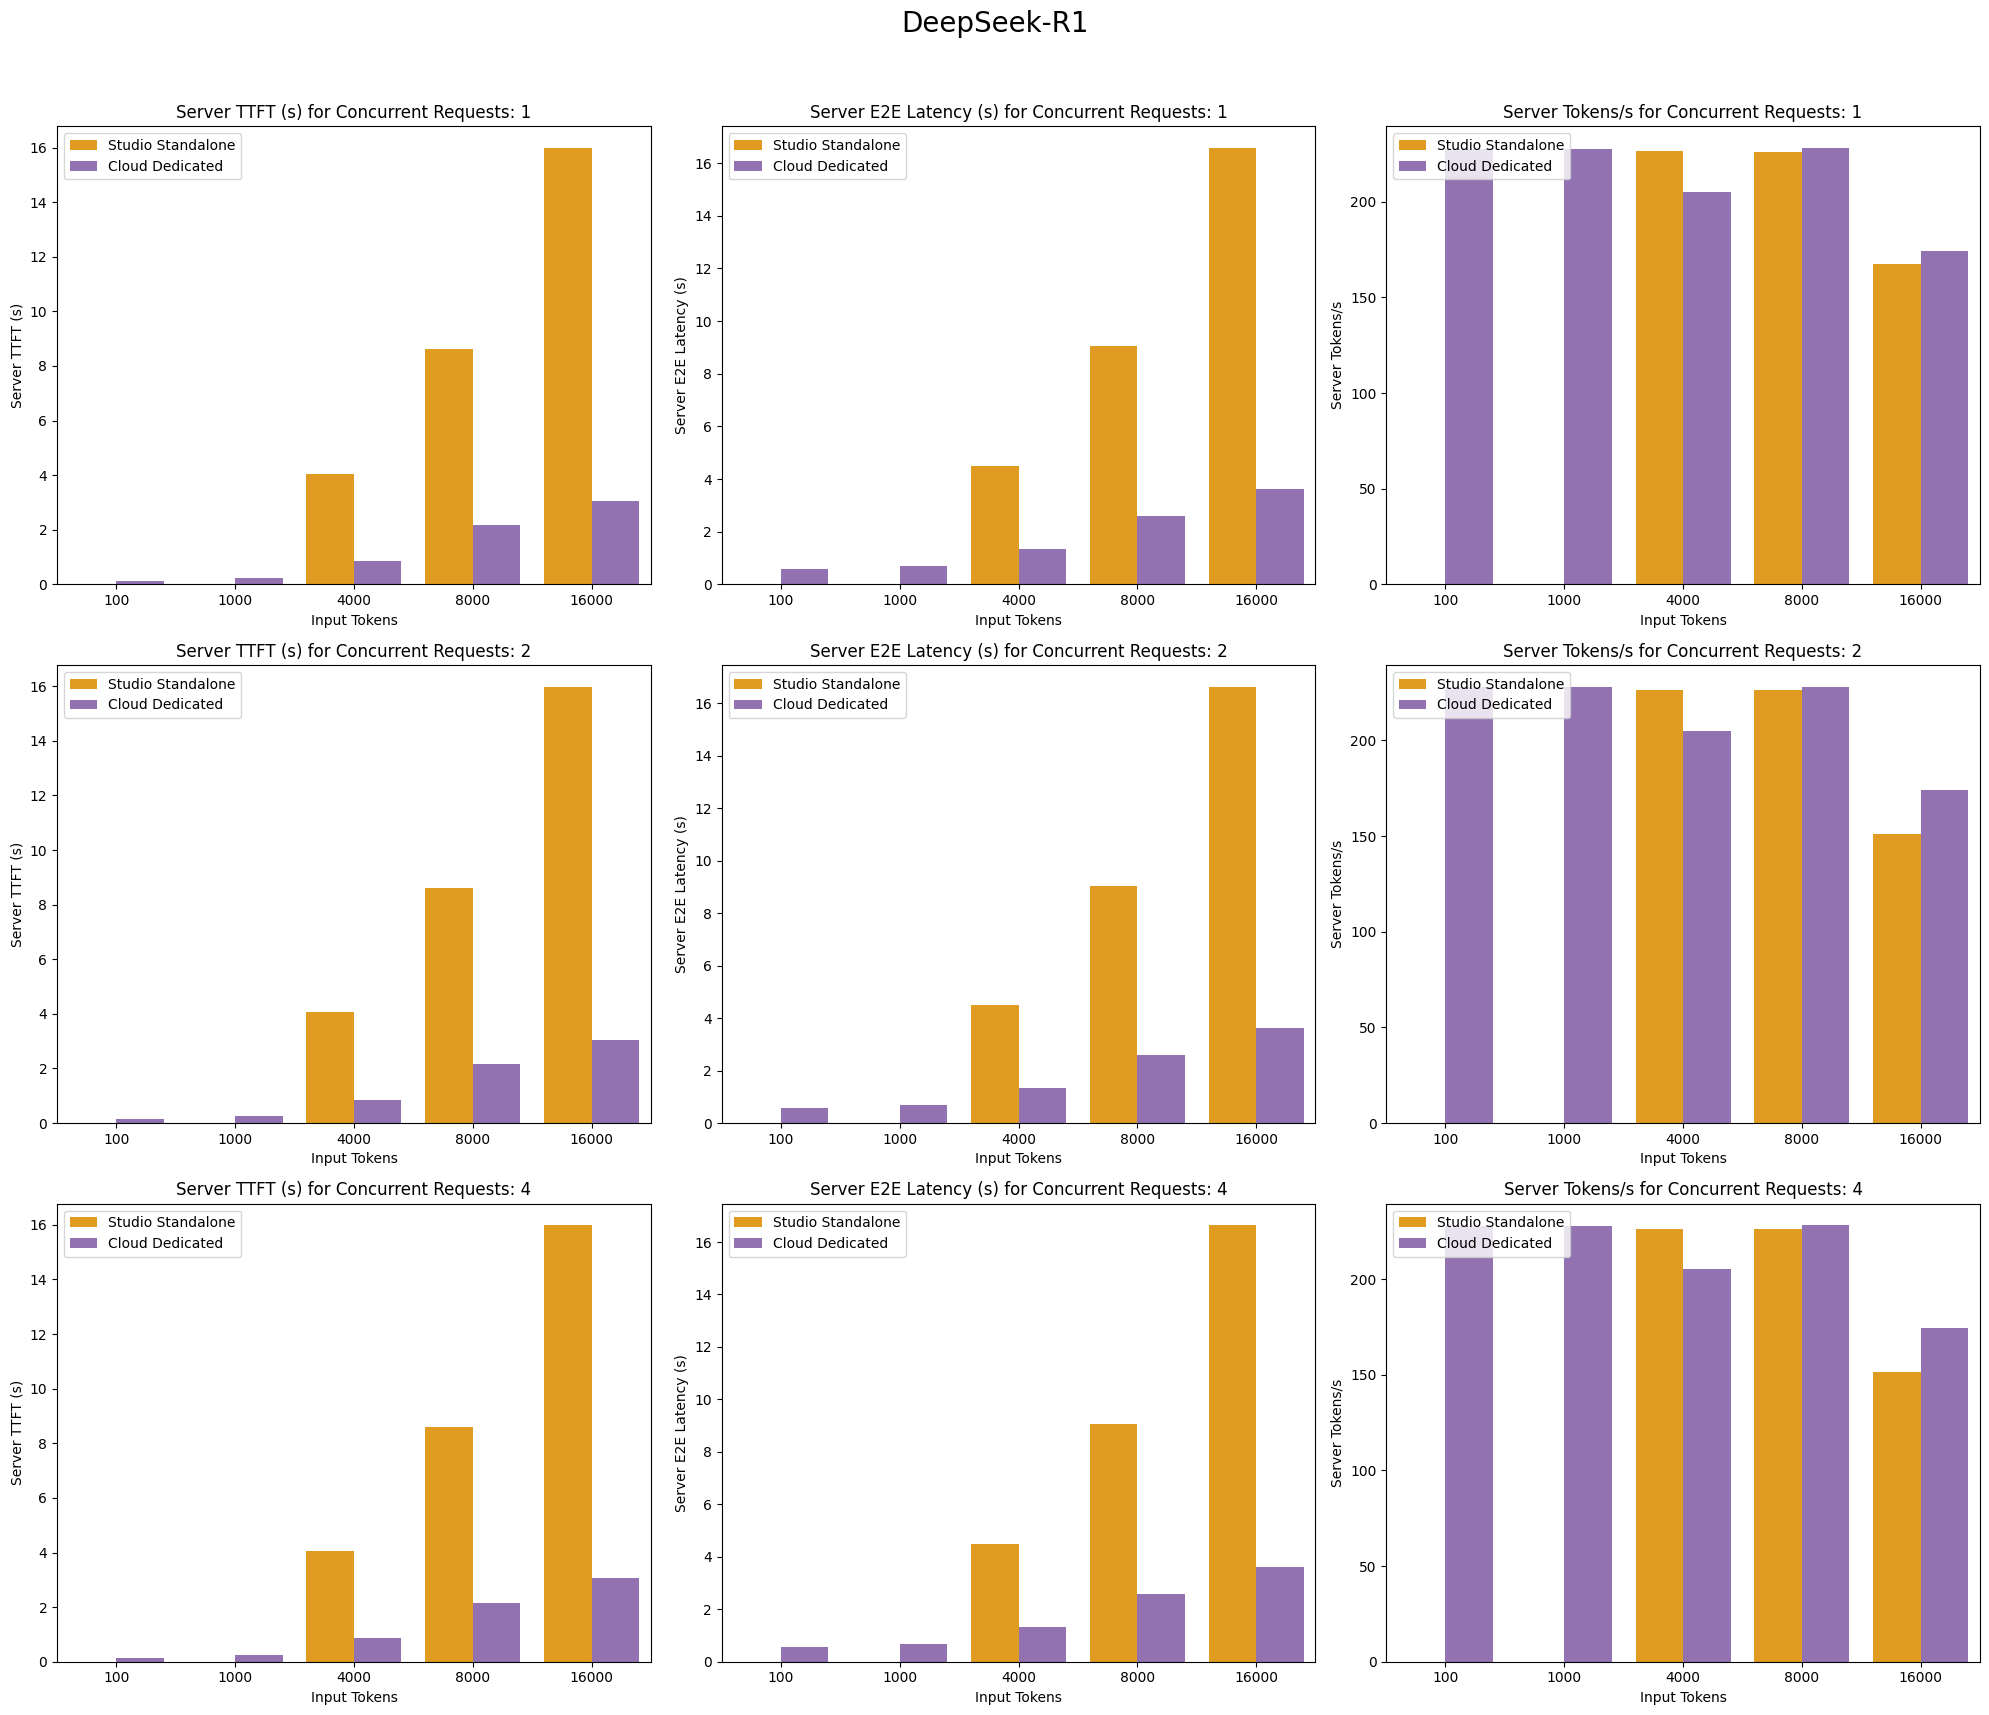

In [67]:
%matplotlib inline
# Set up the figure and axes


fields = {
    "Server TTFT (s)": "server_ttft_s_p50",
    "Server E2E Latency (s)": "server_end_to_end_latency_s_p50",
    "Server Tokens/s": "server_output_token_per_s_p50",
}

plt.clf()
for target_model in target_models:
    fig, axes = plt.subplots(len(concurrent_values), 3, figsize=(20, 6 * len(concurrent_values)), sharex=False)
    fig.suptitle(target_model, fontsize=20)
    for i, concurrent in enumerate(concurrent_values):
        subset = results[results['num_concurrent_requests'] == concurrent]        
        for j, field in enumerate(fields.keys()):
            ax = axes[i, j]                
            sns.barplot(data=subset, x='num_input_tokens', y=fields[field], hue='provider', ax=ax, palette=palette, errorbar=None)
            ax.set_title(f'{field} for Concurrent Requests: {concurrent}')
            ax.set_xlabel('Input Tokens')
            ax.set_ylabel(field)    
            ax.legend(loc=2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()